# XGBoost Analysis

## Setup

In [23]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import shap

%matplotlib inline

In [2]:
# Load data
data = pd.read_csv('data/ames_xgb.csv')

In [3]:
# Create the independent variables and the target
predictors = data.drop('SalePrice', axis=1)
target = data['SalePrice']

In [4]:
# Check columns
column_names = predictors.columns
for column in column_names:
    print(column)

GrLivArea
LotFrontage
LotArea
OverallQual
OverallCond
MasVnrArea
ExterQual
ExterCond
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold
Remod
YrSoldLessBuilt
YrSoldLessRemod
Crisis
MSZoning_A (agr)
MSZoning_C (all)
MSZoning_FV
MSZoning_I (all)
MSZoning_RH
MSZoning_RL
MSZoning_RM
LotShape_IR1
LotShape_IR2
LotShape_IR3
LotShape_Reg
LandContour_Bnk
LandContour_HLS
LandContour_Low
LandContour_Lvl
LotConfig_Corner
LotConfig_CulDSac
LotConfig_FR2
LotConfig_FR3
LotConfig_Inside
LandSlope_Gtl
LandSlope_Mod
LandSlope_Sev
Neighborhood_Blmngtn
Neighborhood_Blueste
Neighborhood_BrDale
Neighborhood_BrkSide
Neighborhood_ClearCr
Neighborhood_CollgCr
Neighborhood_Crawfor
Neighborhood_Edwards
Neighborhood_Gilbert
Neighborhood_Greens
Neighborhood_GrnHill
Neighborhoo

In [5]:
# Check info on predictors
print(predictors.info())    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2576 entries, 0 to 2575
Columns: 278 entries, GrLivArea to MSSubClass_90
dtypes: float64(11), int64(267)
memory usage: 5.5 MB
None


In [6]:
# View data
predictors.head(10)

,GrLivArea,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtFinSF1,BsmtFinSF2,...,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
0,856,0.0,7890,6,6,0.0,3,3,238.0,0.0,...,1,0,0,0,0,0,0,0,0,0
1,1049,42.0,4235,5,5,149.0,4,3,552.0,393.0,...,0,0,0,0,0,0,0,0,0,0
2,1001,60.0,6060,5,9,0.0,4,3,737.0,0.0,...,1,0,0,0,0,0,0,0,0,0
3,1039,80.0,8146,4,8,0.0,4,4,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
4,1665,70.0,8400,8,6,0.0,4,3,643.0,0.0,...,0,0,0,0,1,0,0,0,0,0
5,1922,64.0,7301,7,5,500.0,4,3,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
6,936,60.0,6000,4,4,0.0,2,3,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,1246,53.0,3710,7,5,20.0,4,3,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8,889,74.0,12395,5,6,0.0,3,3,647.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9,1072,35.0,3675,6,5,76.0,3,3,467.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Split Train-Test Sets

In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state=0, test_size = 0.2)

In [8]:
# Check training set features and target
print(X_train.shape)
print(y_train.shape)

(2060, 278)
(2060,)


In [9]:
# Check test set features and target
print(X_test.shape)
print(y_test.shape)

(516, 278)
(516,)


## Data Prep

In [10]:
# Transform Train and Test Set targets to log
y_train = np.log(y_train)
y_test = np.log(y_test)

## Train Model

In [11]:
# Initialize a XGBRegressor object
xgbr = xgb.XGBRegressor()

In [12]:
# Define the grid of hyperparameters to search
params = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10],
    'alpha': [0, 10, 20],
    'n_estimators': [10, 50, 100, 200],
    'colsample_bytree': [0.3, 0.5, 0.7, 1],
    'objective': ['reg:squarederror']
}

In [13]:
# Initialize a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgbr, 
                           param_grid=params, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=1, 
                           n_jobs=-1)

In [14]:
# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [0,

In [15]:
# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

Best parameters: {'alpha': 0, 'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'objective': 'reg:squarederror'}


## Evaluate Model

In [16]:
# Initialize a new XGBoost regressor using the best parameters
best_xgbr = xgb.XGBRegressor(**best_params)

In [17]:
# Fit the best XGBoost regressor to the data
best_xgbr.fit(X_train, y_train)

XGBRegressor(alpha=0, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [18]:
# Predict the train set
y_pred_train = best_xgbr.predict(X_train)

# Compute the R^2 score for the train set
r2_train = r2_score(y_train, y_pred_train)
print(f'R^2 score: {r2_train}')

R^2 score: 0.9874415476531931


In [19]:
# Predict the test set
y_pred_test = best_xgbr.predict(X_test)

# Compute the R^2 score for the test set
r2_test = r2_score(y_test, y_pred_test)
print(f'R^2 score: {r2_test}')

R^2 score: 0.9376809001352175


## Feature Importances

In [20]:
# List top 5 features
importances = best_xgbr.feature_importances_
feature_importances = pd.DataFrame({'Feature': predictors.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances.head(5))

            Feature  Importance
3       OverallQual    0.081931
22       Fireplaces    0.065842
24       GarageCars    0.064644
202  KitchenQual_Ex    0.050427
159     BsmtQual_Ex    0.038184


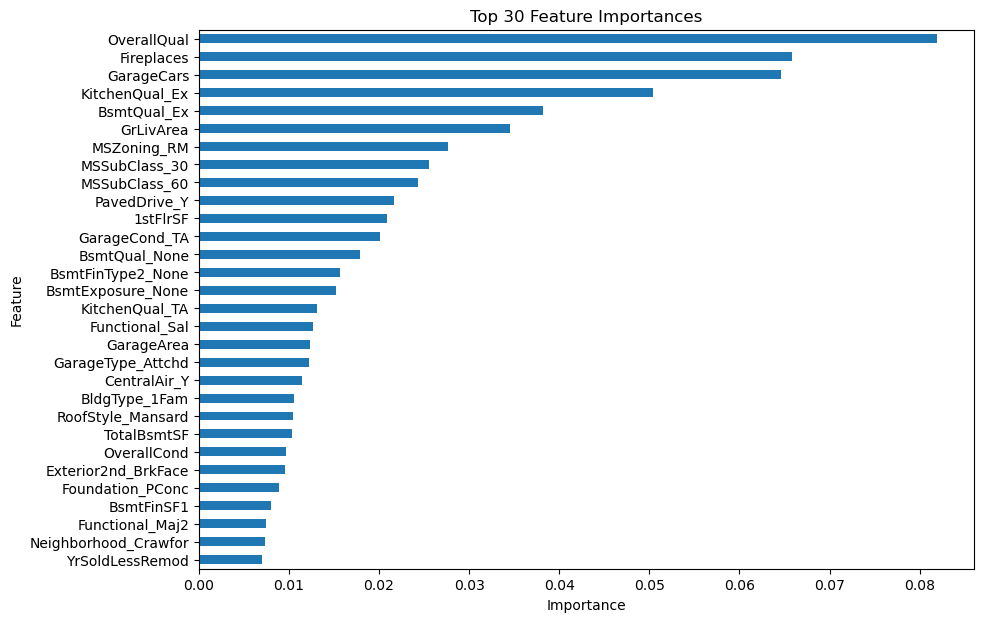

In [21]:
# Select the top 30 features
feature_importances_top_30 = feature_importances.head(30)

# Plot the bar chart
feature_importances_top_30.set_index('Feature')['Importance'].sort_values().plot(kind='barh', figsize=(10,7))
plt.title("Top 30 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")

# Show the plot
plt.show()


## Shapley Values

In [24]:
# Compute the SHAP values
explainer = shap.TreeExplainer(best_xgbr)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [25]:
# Summarize the SHAP values in a DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_train.columns)
shap_df

,GrLivArea,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtFinSF1,BsmtFinSF2,...,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
0,0.068609,0.000173,0.029105,0.049636,-0.008132,-0.002372,0.021177,-5.471492e-06,0.001097,-0.000974,...,0.001283,0.000003,0.000004,-0.000067,0.004768,-0.000299,0.0,0.0,-0.000169,0.000110
1,-0.110219,0.002154,-0.002227,-0.045872,0.012510,-0.001819,-0.011715,3.122110e-04,0.012505,-0.000762,...,0.003188,0.000007,0.000009,-0.000054,-0.000653,-0.000122,0.0,0.0,-0.000169,0.000162
2,0.050614,-0.002750,-0.022403,-0.014762,0.050571,-0.004120,-0.014219,1.322339e-03,0.004670,-0.000756,...,0.001727,0.000003,0.000065,-0.000340,-0.001668,0.002396,0.0,0.0,-0.000123,0.000118
3,0.039036,-0.000576,0.001469,0.050657,-0.010287,-0.003352,-0.008995,6.319397e-08,0.000612,-0.000800,...,0.001589,0.000007,0.000004,-0.000028,0.004768,-0.000255,0.0,0.0,-0.000169,0.000063
4,0.068096,0.000279,0.007397,0.172701,-0.005481,0.021217,0.030306,-5.881826e-06,0.050428,-0.000520,...,0.001612,0.000003,0.000004,-0.000027,0.000032,-0.000057,0.0,0.0,-0.000169,0.000251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,0.040704,-0.001051,-0.076019,0.048632,-0.009675,-0.003531,0.024281,-3.276489e-05,-0.028664,-0.000675,...,0.003905,0.000003,0.000004,-0.000427,-0.001642,-0.000122,0.0,0.0,-0.000169,0.000131
2056,0.036288,0.000277,0.007914,-0.014317,-0.006458,-0.003546,-0.010506,1.140184e-04,-0.024208,-0.000522,...,0.001768,0.000007,0.000004,0.000020,0.004768,-0.000299,0.0,0.0,-0.000169,0.000121
2057,-0.034096,-0.001831,-0.051546,0.056169,0.043727,-0.003861,-0.013946,9.950073e-04,-0.024944,-0.001001,...,0.002984,0.000003,0.000065,-0.000376,0.004768,-0.000106,0.0,0.0,-0.000133,0.000117
2058,-0.104139,-0.000940,-0.021327,-0.046485,0.008684,-0.002431,-0.012344,2.970600e-04,0.012822,-0.001138,...,0.003566,0.000007,0.000003,-0.000049,-0.001668,-0.000122,0.0,0.0,-0.000169,0.000123


In [26]:
# Get the mean absolute SHAP values for each fature
mean_shap_values = np.abs(shap_df).mean().sort_values(ascending=False)

In [29]:
# Print the top 5 features
print(mean_shap_values.head(5))

GrLivArea          0.080920
OverallQual        0.062626
Fireplaces         0.029913
YrSoldLessBuilt    0.029728
1stFlrSF           0.027329
dtype: float32


In [27]:
# Print total number of features
print("Total number of features: ", len(mean_shap_values))

Total number of features:  278


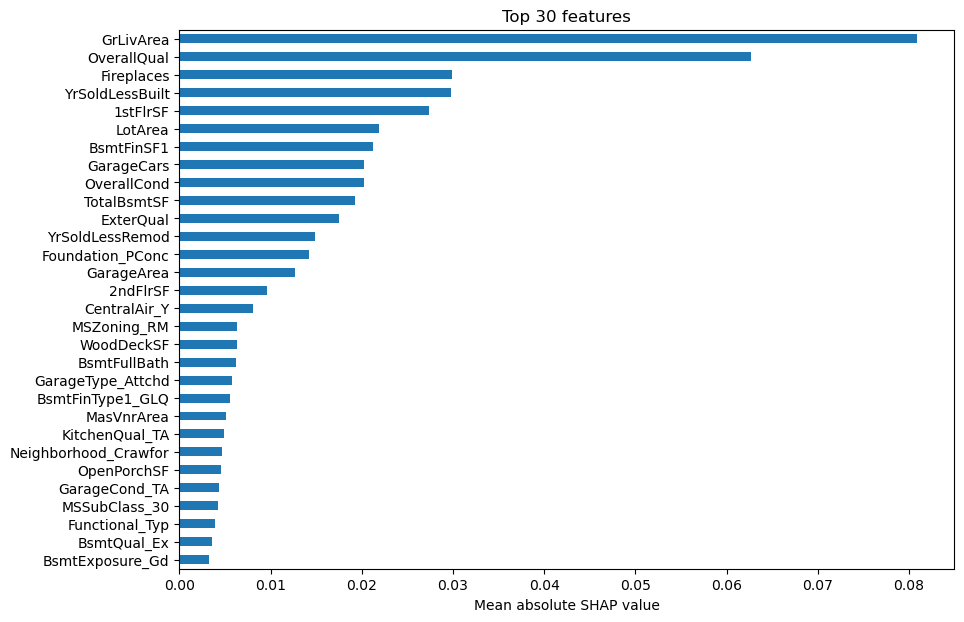

In [28]:
# Plot the top 30 features
mean_shap_values.head(30).plot(kind='barh', figsize=(10, 7))
plt.xlabel('Mean absolute SHAP value')
plt.title('Top 30 features')
plt.gca().invert_yaxis()
plt.show()